In [1]:
rm(list=ls())
library("mlbench")
library("caret")
library("e1071")

Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


# Exercicio 1

## Exercicio 1 - a)

### Generating data

In [2]:
n1 <- 100
mu1 <- c(1,1)
sd1 <- 0.4
xc1 <- cbind(rnorm(n = n1, mean = mu1[1], sd = sd1),
             rnorm(n = n1, mean = mu1[2], sd = sd1),
            0)

n2 <- 100
mu2 <- c(3,3)
sd2 <- 0.4
xc2 <- cbind(rnorm(n = n2, mean = mu2[1], sd = sd2),
             rnorm(n = n2, mean = mu2[2], sd = sd2), 
             1)

data <- data.frame(rbind(xc1, xc2))
colnames(data) <- c("x1", "x2", "class")
head(data)

x1,x2,class
0.9577944,1.3858201,0
0.3556967,0.4321551,0
1.5080849,1.2140546,0
1.4062830,1.1684597,0
1.0378798,0.9517987,0
1.4354443,1.0152221,0


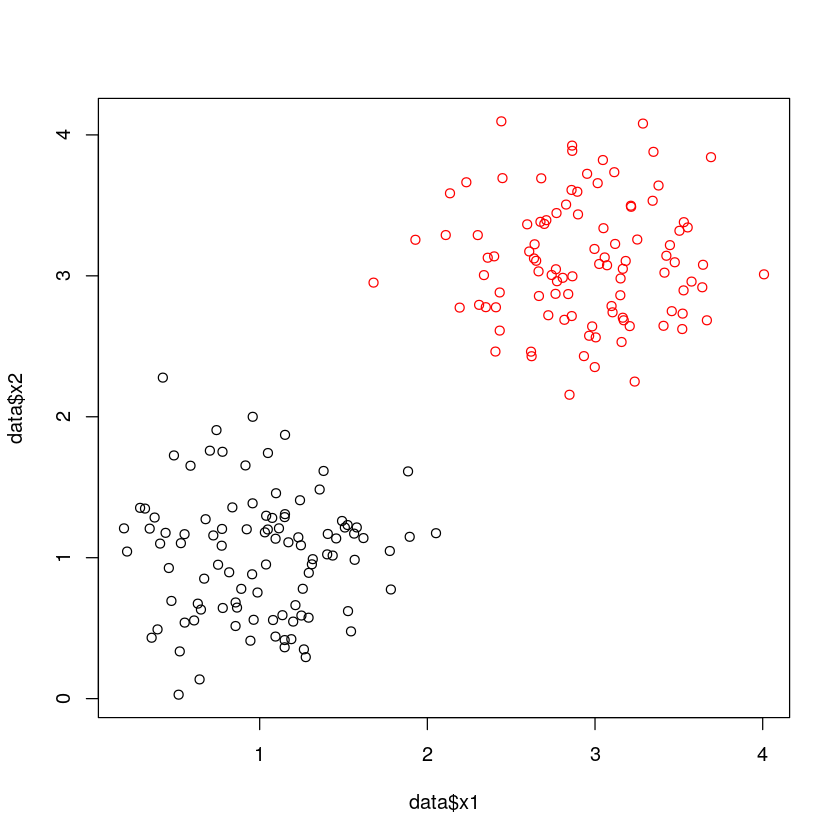

In [3]:
plot(data$x1, data$x2, col=data$class + 1)

### Definição do Perceptron

Yhat = f(XW)

XW = theta

Theta é o threshold

x1w1 + x2w2 = theta

x2 = (w1/w2)x1 + theta/w
2
a = w1/w2 ; b = theta/w2


x = [1, x1, x2]

w = [-theta, w1, w2]

### Treinamento

Só importa quando y != yhat. 

W = W + eta * error * X

In [4]:
evaluate_perceptron <- function(perceptron, data){
    nrows <- dim(data)[1] 
    ndims <- dim(data)[2] - 1
    yhat_vec <- matrix(ncol= 1, nrow = nrows)
    W <- as.matrix(perceptron$weights)
    
    # Loops over data
    for(row in 1:nrows){

        xi <- t(data[row,1:ndims])
        yi <- data[row, ndims+1]

        # Calculates yhat
        yhat_vec[row] <- 1.0 * (xi %*% W >= 0 )
    }
    
    confMat <- confusionMatrix(as.factor(yhat_vec), as.factor(data[,ncol(data)]))
    error <- 100 * sum(yhat_vec != data[,ndims+1]) / nrows
    
    return(list("yhat" = yhat_vec, 
                "error" = error,
                "confusionMatrix" = confMat))
}

In [5]:
train_perceptron <- function(data, 
                             eta, 
                             tol,
                             nepochs,
                             shuffle_data = T){
# This function assumes the bias term has already 
# been added if necessary and the classes of each 
# observation are in the last column of the input data.
    
    nrows <- dim(data)[1] 
    ndims <- dim(data)[2] - 1
    error_vec <- matrix(0, nrow=1, ncol=nepochs)

    # Randomly initializes weight vector
    W <- as.matrix(runif(ndims, -1, 1), nrow=ndims, ncol=1)
    
    for (epoch in 1:nepochs){
        
        # Shuffles data
        if(shuffle_data){
            data_seq <- data[sample(nrows),]
        } else {
            data_seq <- data
        }

        # Loops over data
        for(row in 1:nrows){
            
            xi <- t(data_seq[row,1:ndims])
            yi <- data_seq[row, ndims+1]
            
            # Calculates yhat
            yhat <- 1.0 * as.numeric(xi %*% W >= 0 )
            # Compares with true y
            error <- as.vector(yi - yhat)
#             cat(sprintf("%i %i %i\n", yi, yhat, error))
            # Adjusts weight vector
            dw <- t(eta * error * xi)
            W <- W + dw
            # Accumulates error
            error_vec[epoch] <- error_vec[epoch] + abs(error) 
        }
        
        # Stopping criteria: error smaller than tolerance
        if (error_vec[epoch] < tol){
            print("Stopping due to error smaller than tol.")
            break
        }
    }
    return(list("weights" = W, "errors" = error_vec))
}


In [6]:
tol <- 0.00001
eta <- 0.01
nepochs <- 10
shuffle_data <- T
data_aug <- data.matrix(cbind(-1,data))

perceptron <- train_perceptron(data = data_aug, 
                             eta = eta, 
                             tol = tol,
                             nepochs = nepochs,
                             shuffle_data = shuffle_data)
perceptron

[1] "Stopping due to error smaller than tol."


$weights
          [,1]
-1 0,096159045
x1 0,041594379
x2 0,008965983

$errors
     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
[1,]  111   12    0    0    0    0    0    0    0     0

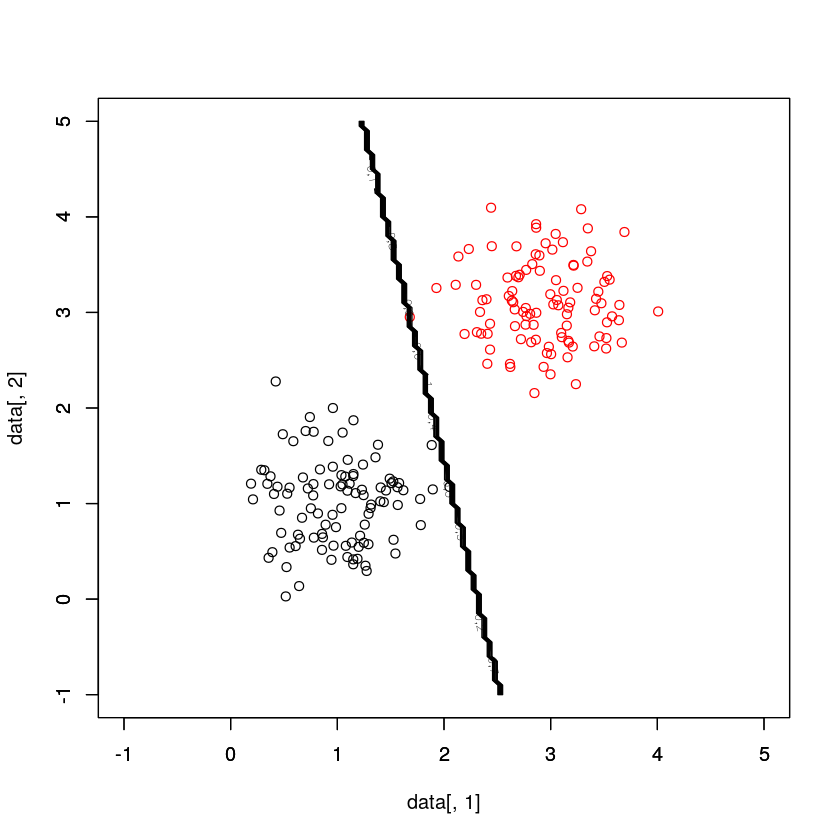

In [7]:
# Plotting surface
xseq <- seq(-1,5,0.05)
lseq <- length(xseq)
MZ <- matrix(0, nrow=lseq, ncol=lseq)

for(i in 1:lseq){
    for(j in 1:lseq){
        xi <- as.matrix(cbind(-1, xseq[i], xseq[j]), nrow = 1, ncol=ndims)
        MZ[i,j] <- 1.0 * (xi %*% perceptron$weights >= 0 )
    }
}

lim=c(-1,5)
plot(data[,1], data[,2], col=data[,3]+1, xlim=lim, ylim=lim)
par(new=T)
contour(x= xseq, y=xseq, z=MZ, xlim=lim, ylim=lim)

In [8]:
# Extracting line coefficients
theta = perceptron$weights[1]
w1 = perceptron$weights[2]
w2 = perceptron$weights[3]
a = w1/w2 
b = theta/w2
cat(sprintf("x2 = %f * x1 + %f", a, b))

x2 = 4,639132 * x1 + 10,724874

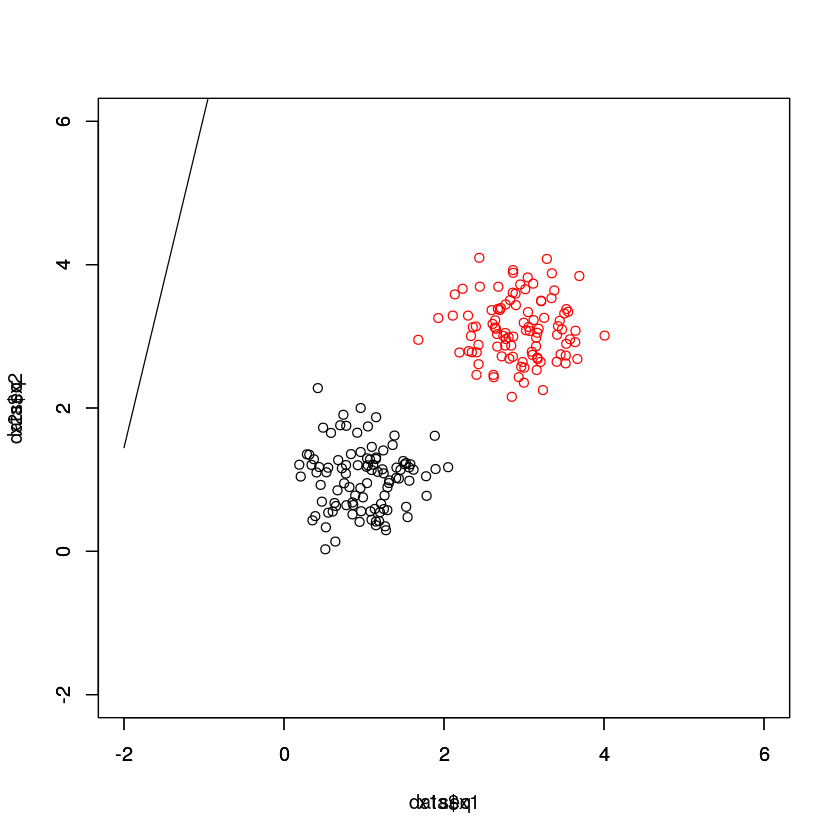

In [9]:
# Evaluating line
x1seq <- seq(-2, 6, 0.1)
x2seq <- a * x1seq + b

# Plotting result
lim=c(-2,6)
plot(data$x1, data$x2, col=data$class + 1, xlim=lim, ylim=lim)
par(new=T)
plot(x1seq, x2seq, type='l', xlim=lim, ylim=lim)

In [10]:
output <- evaluate_perceptron(perceptron, data_aug)
output$error

[1] 0

## Exercicio 1 - b) Breast Cancer

In [11]:
data(BreastCancer)
head(BreastCancer)

Id,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class
1000025,5,1,1,1,2,1,3,1,1,benign
1002945,5,4,4,5,7,10,3,2,1,benign
1015425,3,1,1,1,2,2,3,1,1,benign
1016277,6,8,8,1,3,4,3,7,1,benign
1017023,4,1,1,3,2,1,3,1,1,benign
1017122,8,10,10,8,7,10,9,7,1,malignant


In [12]:
# Removing Id and Class
bc <- BreastCancer[,!names(BreastCancer) %in% c("Id", "Class")]
# Defining benign as 1 as malign as 0
class <- 1 * (BreastCancer$Class == "benign")
# Adding -1 column and numeric class
bc <- cbind(-1, bc, class)
# Removing NA
bc <- bc[complete.cases(bc), ]
# Converting to numeric matrix
bc <- data.matrix(bc)
head(bc)

# 1.0 * (BreastCancer$Class == "benign")

-1,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,class
-1,5,1,1,1,2,1,3,1,1,1
-1,5,4,4,5,7,10,3,2,1,1
-1,3,1,1,1,2,2,3,1,1,1
-1,6,8,8,1,3,4,3,7,1,1
-1,4,1,1,3,2,1,3,1,1,1
-1,8,10,10,8,7,10,9,7,1,0


In [13]:
tol <- 0.0001
eta <- 0.02
nepochs <- 50
shuffle_data <- T

bc_perceptron <- train_perceptron(data = bc, 
                             eta = eta, 
                             tol = tol,
                             nepochs = nepochs,
                             shuffle_data = shuffle_data)
bc_perceptron

$weights
                       [,1]
-1              -5,96207332
Cl.thickness    -0,25466940
Cell.size       -0,03459754
Cell.shape      -0,24743954
Marg.adhesion   -0,21411163
Epith.c.size    -0,07811762
Bare.nuclei     -0,54390338
Bl.cromatin     -0,30674882
Normal.nucleoli -0,14188236
Mitoses         -0,26254562

$errors
     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12] [,13] [,14]
[1,]   98   57   54   48   41   55   39   44   41    39    37    39    34    40
     [,15] [,16] [,17] [,18] [,19] [,20] [,21] [,22] [,23] [,24] [,25] [,26]
[1,]    37    38    35    35    37    31    32    37    36    29    30    40
     [,27] [,28] [,29] [,30] [,31] [,32] [,33] [,34] [,35] [,36] [,37] [,38]
[1,]    27    32    31    32    28    26    37    29    32    36    34    34
     [,39] [,40] [,41] [,42] [,43] [,44] [,45] [,46] [,47] [,48] [,49] [,50]
[1,]    31    25    25    35    28    24    30    29    29    34    23    27

In [14]:
head(bc[,1:ncol(bc)-1])

-1,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses
-1,5,1,1,1,2,1,3,1,1
-1,5,4,4,5,7,10,3,2,1
-1,3,1,1,1,2,2,3,1,1
-1,6,8,8,1,3,4,3,7,1
-1,4,1,1,3,2,1,3,1,1
-1,8,10,10,8,7,10,9,7,1


In [15]:
dim(bc_perceptron$weights)

[1] 10  1

In [16]:
bc_results <- evaluate_perceptron(bc_perceptron, data.matrix(bc[,1:ncol(bc)]))

In [20]:
bc_results$confusionMatrix

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 238  17
         1   1 427
                                          
               Accuracy : 0,9736          
                 95% CI : (0,9587, 0,9843)
    No Information Rate : 0,6501          
    P-Value [Acc > NIR] : < 2,2e-16       
                                          
                  Kappa : 0,943           
                                          
 Mcnemar's Test P-Value : 0,000407        
                                          
            Sensitivity : 0,9958          
            Specificity : 0,9617          
         Pos Pred Value : 0,9333          
         Neg Pred Value : 0,9977          
             Prevalence : 0,3499          
         Detection Rate : 0,3485          
   Detection Prevalence : 0,3734          
      Balanced Accuracy : 0,9788          
                                          
       'Positive' Class : 0               
                              

# Exercicio 2

In [21]:
rm(list=ls())

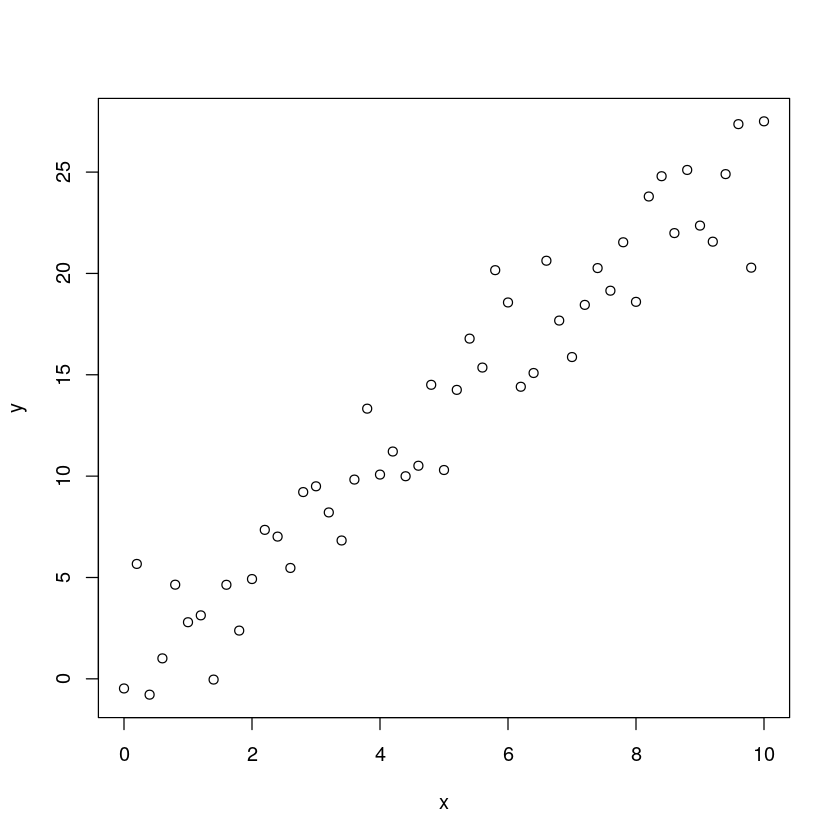

In [74]:
x <- seq(0,10,0.2)
a <- 2.5
b <- 1
sd <- 2
y <- a * x + b + rnorm(length(x), sd = sd)
plot(x, y)

In [75]:
train_adaline <- function(data, 
                          eta, 
                          tol,
                          nepochs,
                          shuffle_data = T){
# This function assumes the bias term has already 
# been added if necessary and the classes of each 
# observation are in the last column of the input data.
    
    nrows <- dim(data)[1] 
    ndims <- dim(data)[2]-1
    error_vec <- matrix(0, nrow=1, ncol=nepochs)

    # Randomly initializes weight vector
    W <- as.matrix(runif(ndims, -1, 1), nrow=ndims, ncol=1)
    
    for (epoch in 1:nepochs){
        
        # Shuffles data
        if(shuffle_data){
            data_seq <- data[sample(nrows),]
        } else {
            data_seq <- data
        }

        # Loops over data
        for(row in 1:nrows){
            
            xi <- t(data_seq[row,1:ndims])
            yi <- data_seq[row, ndims+1]
            
            # Calculates yhat
            yhat <- xi %*% W
            # Compares with true y
            error <- as.vector(yi - yhat)
#             cat(sprintf("%i %i %i\n", yi, yhat, error))
            # Adjusts weight vector
            dw <- t(eta * error * xi)
            W <- W + dw
            # Accumulates error
            error_vec[epoch] <- error_vec[epoch] + abs(error) 
        }
        
        # Stopping criteria: error smaller than tolerance
        if (error_vec[epoch] < tol){
            print("Stopping due to error smaller than tol.")
            break
        }
    }
    return(list("weights" = W, "errors" = error_vec))
}


In [76]:
evaluate_adaline <- function(adaline, data){
# This function assumes the bias term has already 
# been added if necessary and the classes of each 
# observation are in the last column of the input data.
    
    nrows <- dim(data)[1] 
    ndims <- dim(data)[2] -1 

    # Randomly initializes weight vector
    W <- adaline$weights
    yhat_vec <- matrix(nrow=nrow(data))
    # Loops over data
    for(row in 1:nrows){

        xi <- t(data[row, 1:ndims])
        # Calculates yhat
        yhat_vec[row] <- xi %*% W
    }
    
    mse = mean((yhat_vec - data[,ndims+1])^2) 
    
    return(list("yhat" = yhat_vec, "mse" = mse))
}


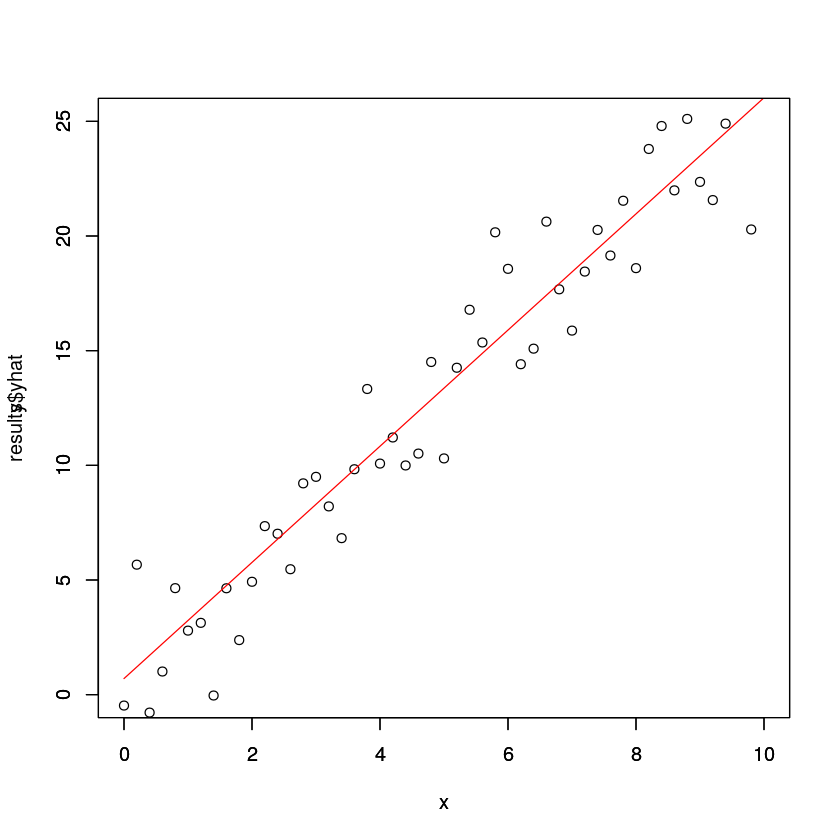

In [77]:
adaline = train_adaline(data=data.matrix(cbind(1, x, y)),
             eta = 0.001,
             tol = 0.0001,
             nepochs = 20)

results <- evaluate_adaline(adaline, cbind(1,x,y))
plot(x,y, xlim=c(0,10), ylim=c(0,25))
par(new=T)
plot(x,results$yhat, type='l', col='red', xlim=c(0,10), ylim=c(0,25))

In [78]:
results$mse

[1] 4,564046

In [80]:
var <- sd ^ 2
var

[1] 4

Obtenha o erro médio
quadrático. Como ele se compara com a variância do ruído quando o número de
pontos é cresce? Discuta.

## Exercicio 2 - b) Building

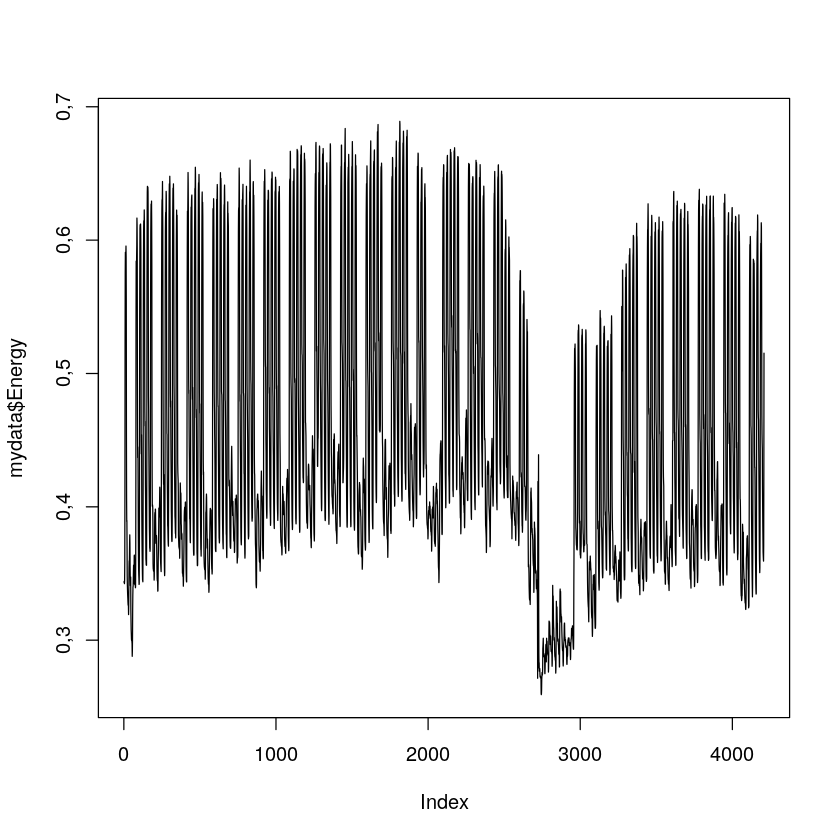

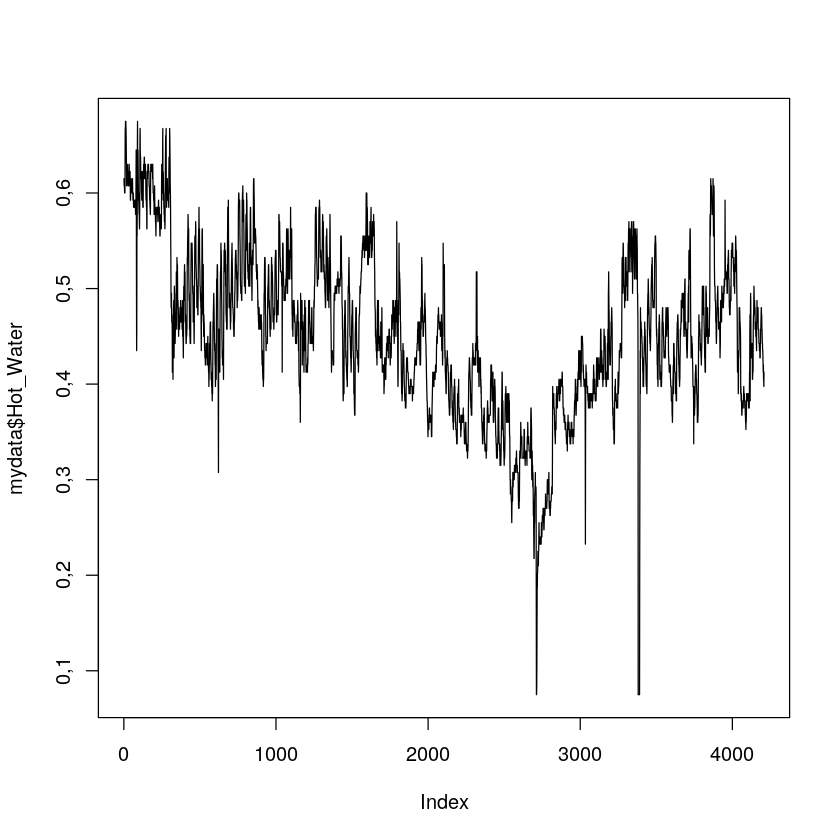

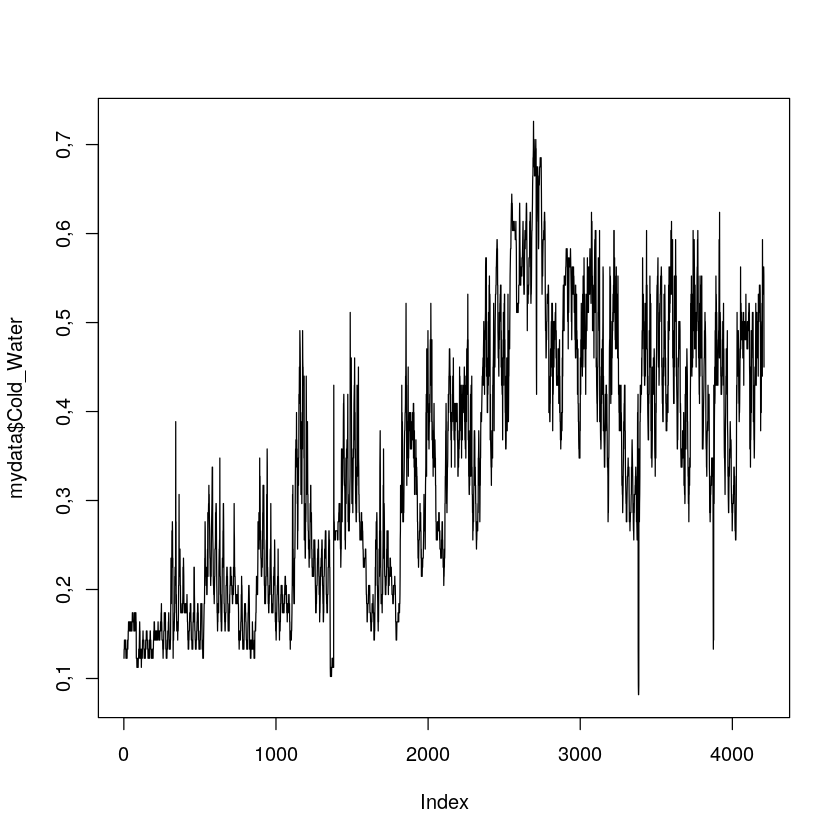

In [82]:
#  Training data 
#  14 coded inputs :
#    MONTH  DAY  YEAR  HOUR  TEMP  HUMID  SOLAR  WIND  WBE  WBCW  WBHW
#  3 outputs (Consumption of) :
#    Electrical Energy Hot Water Cold Water
# bool_in=0
# real_in=14
# bool_out=0
# real_out=3
# training_examples=2104
# validation_examples=1052
# test_examples=1052

mydata = read.csv("BUILDING1paraR.DT", sep=" ")

plot(mydata$Energy,type="l")
plot(mydata$Hot_Water,type="l")
plot(mydata$Cold_Water,type="l")

In [85]:
head(mydata)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,Energy,Hot_Water,Cold_Water
1,0,0,0,0,0,0,"0,833333","-0,826087",1,"0,819","0,736","0,00943396","0,272143","0,343433","0,6150","0,122727"
1,0,0,0,0,0,0,"0,750000","-0,739130",1,"0,807","0,748","0,00943396","0,283571","0,344118","0,6075","0,132955"
1,0,0,0,0,0,0,"0,666667","-0,652174",1,"0,797","0,776","0,00943396","0,275714","0,343848","0,6075","0,132955"
1,0,0,0,0,0,0,"0,583333","-0,565217",1,"0,790","0,788","0,00952830","0,217143","0,342374","0,6075","0,143182"
1,0,0,0,0,0,0,"0,500000","-0,478261",1,"0,789","0,796","0,00952830","0,202857","0,344832","0,6000","0,143182"
1,0,0,0,0,0,0,"0,416667","-0,391304",1,"0,785","0,808","0,00990566","0,138214","0,357895","0,6000","0,143182"


In [91]:
# Removing Output variables
building_data <- mydata[,!names(mydata) %in% c("Energy", "Hot_Water", "Cold_Water")]
# Adding 1 column and numeric class
building_data <- cbind(1, building_data)
# Converting to numeric matrix
building_data <- data.matrix(building_data)
head(building_data)

1,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
1,1,0,0,0,0,0,0,"0,833333","-0,826087",1,"0,819","0,736","0,00943396","0,272143"
1,1,0,0,0,0,0,0,"0,750000","-0,739130",1,"0,807","0,748","0,00943396","0,283571"
1,1,0,0,0,0,0,0,"0,666667","-0,652174",1,"0,797","0,776","0,00943396","0,275714"
1,1,0,0,0,0,0,0,"0,583333","-0,565217",1,"0,790","0,788","0,00952830","0,217143"
1,1,0,0,0,0,0,0,"0,500000","-0,478261",1,"0,789","0,796","0,00952830","0,202857"
1,1,0,0,0,0,0,0,"0,416667","-0,391304",1,"0,785","0,808","0,00990566","0,138214"


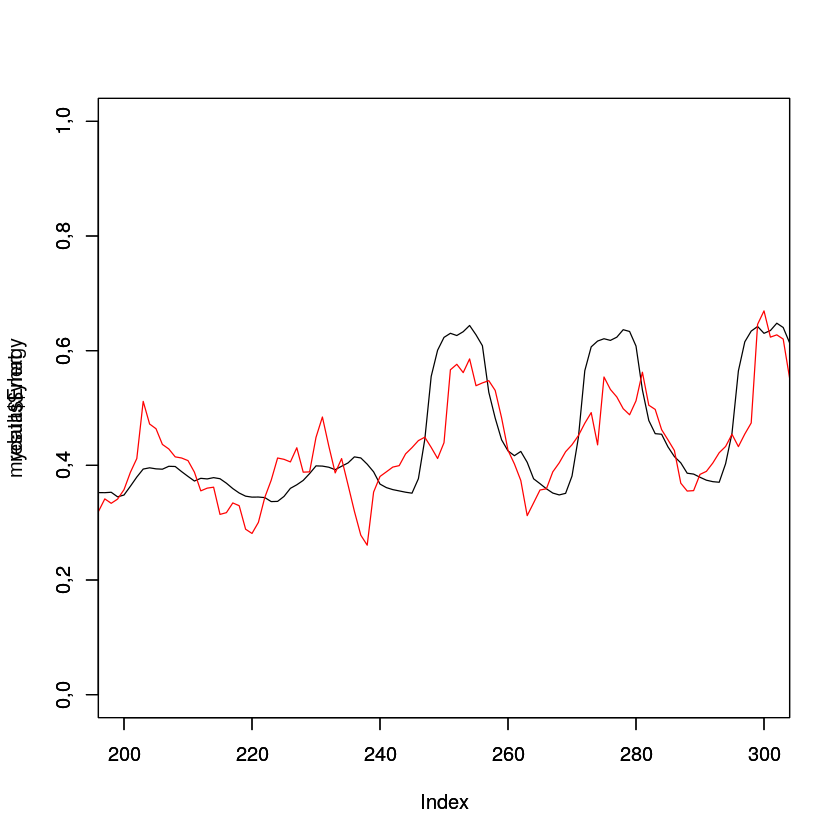

In [116]:
building_energy <- cbind(building_data, mydata$Energy)
building_adaline = train_adaline(data=data.matrix(building_energy),
             eta = 0.001,
             tol = 0.0001,
             nepochs = 10)

results <- evaluate_adaline(building_adaline, building_energy)
xlimplot=c(200,300)
ylimplot=c(0,1)
plot(mydata$Energy, type='l', xlim=xlimplot, ylim=ylimplot)
par(new=T)
plot(results$yhat, col="red", type='l', xlim=xlimplot, ylim=ylimplot)

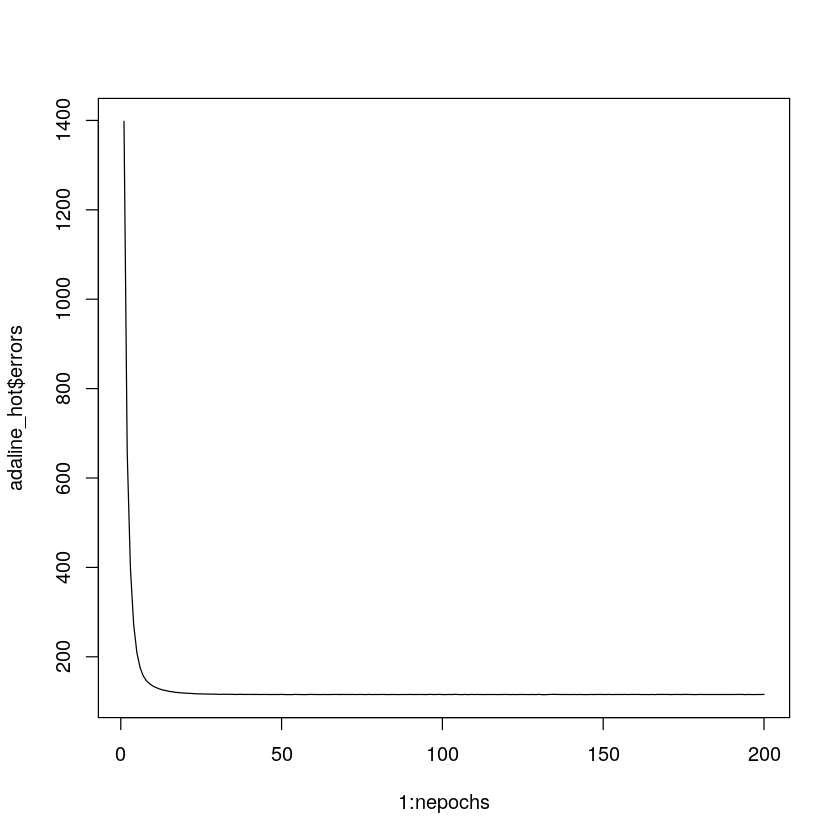

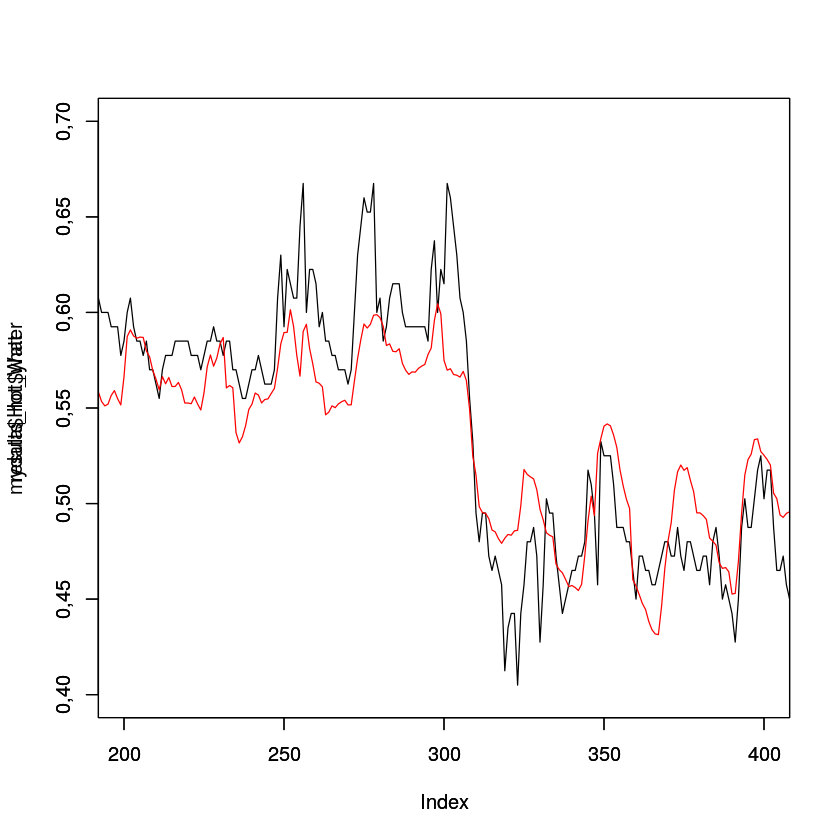

In [139]:
building_hot <- cbind(building_data, mydata$Hot_Water)
nepochs = 200
adaline_hot = train_adaline(data=data.matrix(building_hot),
             eta = 0.002,
             tol = 0.0001,
             nepochs = nepochs)
results_hot <- evaluate_adaline(adaline_hot, building_hot)
plot(1:nepochs, adaline_hot$errors, 'l')
xlimplot=c(200,400)
ylimplot=c(0.4,0.7)
plot(mydata$Hot_Water, type='l', xlim=xlimplot, ylim=ylimplot)
par(new=T)
plot(results_hot$yhat, col="red", type='l', xlim=xlimplot, ylim=ylimplot)

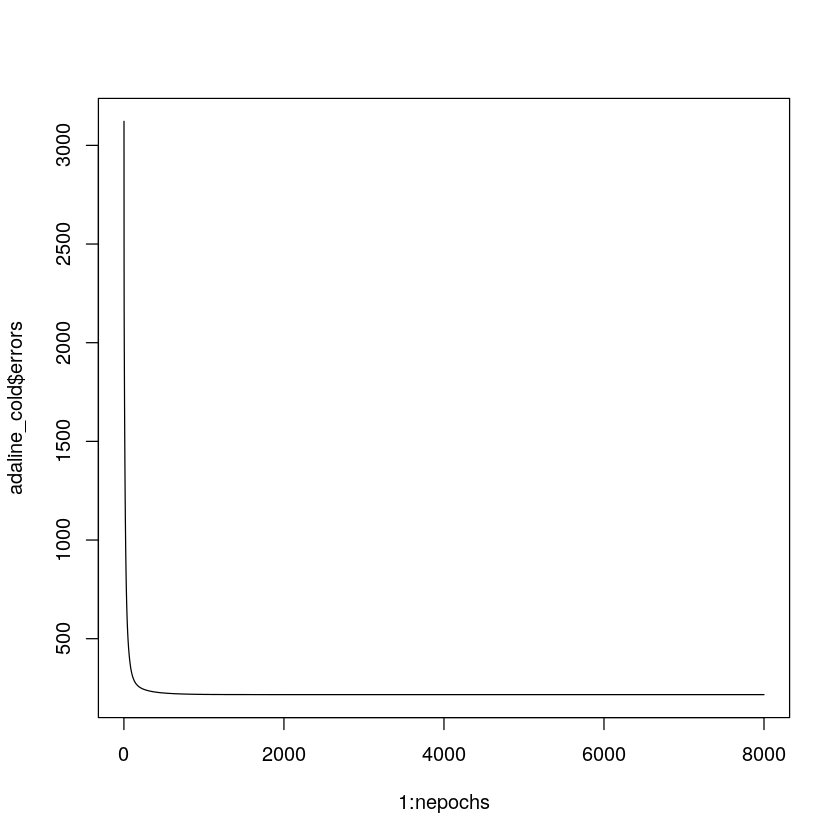

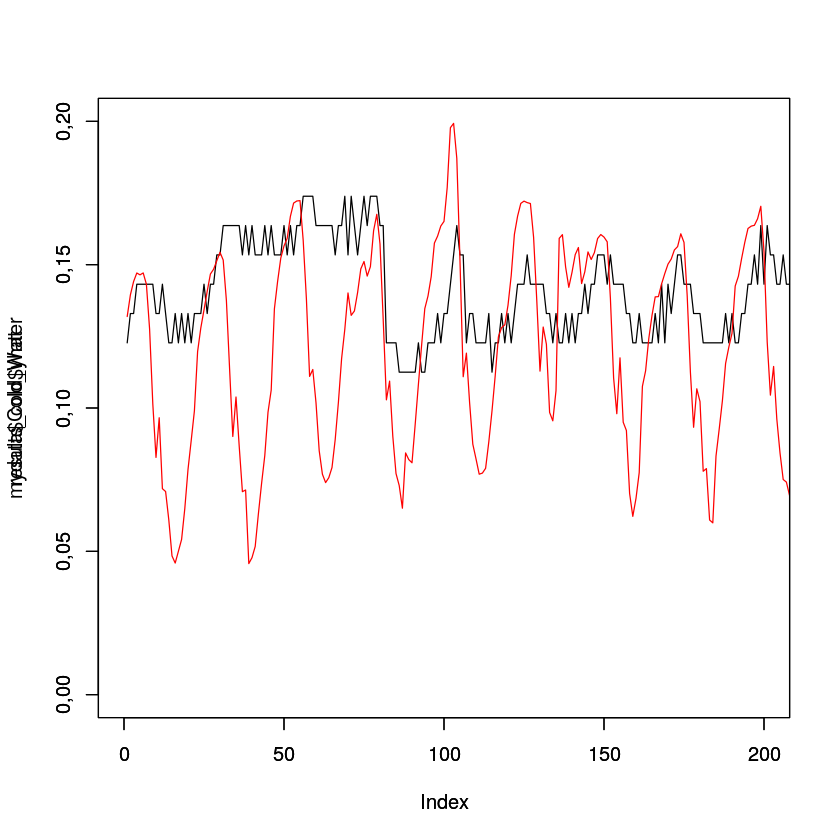

In [144]:
building_cold <- cbind(building_data, mydata$Cold_Water)
nepochs = 8000
adaline_cold <- train_adaline(data=data.matrix(building_cold),
             eta = 0.0001,
             tol = 0.00001,
             nepochs = nepochs)
plot(1:nepochs, adaline_cold$errors, 'l')
results_cold <- evaluate_adaline(adaline_cold, building_cold)
xlimplot=c(0,200)
ylimplot=c(0,0.2)
plot(mydata$Cold_Water, type='l', xlim=xlimplot, ylim=ylimplot)
par(new=T)
plot(results_cold$yhat, col="red", type='l', xlim=xlimplot, ylim=ylimplot)

In [149]:
results$mse

[1] 0,007335054

In [147]:
results_hot$mse

[1] 0,001497834

In [146]:
results_cold$mse

[1] 0,00401852